Методы стратификации работают в случае стратифицированного семплирования, либо же случайного семплирования. Во втором случае метод называется постстратификацией. Однако, при наличии сильных перекосов в соотношении между стратами вероятность ошибки 1 рода может сильно увеличиваться.

Промоделируем распределение разности
* обычного среднего
* стратифицированного среднего

In [ ]:
import scipy.stats as sps
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from statsmodels.stats.proportion import proportion_confint

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3, palette='Set2')

from functools import partial

In [ ]:
total_size = 10_000  # Общее количество объектов в данных
sample_size = 500  # Размер выборки
n_iter = 50_000  # Количество итераций семплирования
lw = 5

Вспомогательные функции:

In [ ]:
def calculate_strata_weights(data):
    '''
    Вычисляет веса страт.

    :param data: исходные данные
    :return: веса страт
    '''

    strata_weights = data.groupby(by='strata')['sample'].count()
    strata_weights = strata_weights / strata_weights.sum()
    return strata_weights

def weighted_mean(data, weights):
    '''
    Вычисляет взвешенное среднее.

    :param data: данные
    :param weights: веса страт
    :return: взвешенное среднее
    '''

    strata_means = data.groupby(by='strata')['sample'].mean()
    return (strata_means * weights).sum()

def random_sampler(data, sample_size):
    '''
    Случайное семплирование двух групп одного размера из данных.

    :param data: исходные данные
    :param sample_size: размер группы
    :return: две группы данных
    '''

    choiced = data.sample(n=2 * sample_size)
    return choiced.iloc[:sample_size], choiced.iloc[sample_size:]

def weighted_var(data, strata_weights):
    '''
    Вычисляет взвешенную дисперсию при стратификации.

    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    '''

    strata_vars = data.groupby(by='strata')['sample'].var()
    return (strata_vars * strata_weights).sum() / len(data)

def weighted_post_var(data, strata_weights):
    '''
    Вычисляет взвешенную дисперсию при постстратификации.

    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    '''

    strata_vars = data.groupby(by='strata')['sample'].var()
    weighted_var = (strata_vars * strata_weights).sum() / len(data)
    post_addition = (strata_vars * (1-strata_weights)).sum() / (len(data)**2)
    return weighted_var + post_addition

def simple_var(data, strata_weights):
    '''
    Вычисляет обычную дисперсию при случайном семплировании.

    :param data: данные
    :param strata_weights: веса страт, не используется, нужен для совместимости
    :return: дисперсия
    '''

    return data['sample'].var() / len(data)

In [ ]:
def calculate_strata_weights(data):
    '''
    Вычисляет веса страт.

    :param data: исходные данные
    :return: веса страт
    '''

    strata_weights = data.groupby(by='strata')['sample'].count()
    strata_weights = strata_weights / strata_weights.sum()
    return strata_weights

def random_sampler(data, sample_size):
    '''
    Случайное семплирование двух групп одного размера из данных.

    :param data: исходные данные
    :param sample_size: размер группы
    :return: две группы данных
    '''

    choiced = data.sample(n=2 * sample_size)
    return choiced.iloc[:sample_size], choiced.iloc[sample_size:]

def weighted_sampler(data, sample_size, strata_weights='default'):
    '''
    Семплирование выборок по стратам с заданными весами.

    :param data: исходные данные
    :param sample_size: размер выборок
    :param strata_weights: веса страт или же 'default' если их надо определить из данных
    :return: две выборки
    '''

    groupped = data.groupby(by='strata')

    if str(strata_weights) == 'default':
        # Веса страт определяем по данным
        strata_weights = groupped['sample'].count()
        strata_weights = strata_weights / strata_weights.sum()
    else:
        # Веса страт заданы
        strata_weights = np.array(strata_weights)

    # Размер выборок по стратам
    strata_sample_size = np.floor(sample_size * strata_weights + 0.5).astype(int)

    a_group, b_group = [], []
    # Генерируем отдельно из каждой страты
    for i, strata in enumerate(groupped):
        a, b = random_sampler(strata[1], strata_sample_size[i])
        a_group.append(a)
        b_group.append(b)

    return pd.concat(a_group), pd.concat(b_group)

In [ ]:
def generate_data(size, p=0.6, shift=5, scale_factor=1):
    '''
    Генерация общего объема данных.

    :param size: размер данных
    :param p: вероятность 1-й страты
    :param shift: смещение 1-й страты
    :param scale_factor: множитель масштаба 1-й страты
    :return: сгенерированные данные
    '''

    data = pd.DataFrame()
    data['strata'] = sps.bernoulli(p=p).rvs(size=size)
    data['sample'] = sps.norm.rvs(size=size) * (1 + scale_factor * data['strata']) \
                        + shift*data['strata']
    return data

def simple_mean(data, weights):
    '''
    Вычисляет обычное выборочное среднее

    :param data: данные
    :param weights: не используется, нужен для совместимости
    :return: выборочное среднее
    '''

    return data['sample'].mean()

def weighted_sampler(data, sample_size, strata_weights='default'):
    '''
    Семплирование выборок по стратам с заданными весами.

    :param data: исходные данные
    :param sample_size: размер выборок
    :param strata_weights: веса страт или же 'default' если их надо определить из данных
    :return: две выборки
    '''
    groupped = data.groupby(by='strata')

    if strata_weights == 'default':
        # Веса страт определяем по данным
        strata_weights = calculate_strata_weights(data)
    else:
        # Веса страт заданы
        strata_weights = np.array(strata_weights)

    # Размер выборок по стратам
    strata_sample_size = np.floor(sample_size * strata_weights + 0.5).astype(int)

    a_group, b_group = [], []
    # Генерируем отдельно из каждой страты
    for i, strata in enumerate(groupped):
        a, b = random_sampler(strata[1], strata_sample_size[i])
        a_group.append(a)
        b_group.append(b)

    return pd.concat(a_group), pd.concat(b_group)

def sample_mean_diff(sampler, mean_function, data, sample_size, n_iter):
    '''
    Реализация итераций семплирования двух групп и вычисления разности средних.

    :param sampler: функция семплирования двух групп
    :param mean_function: функция вычисления среднего
    :param data: исходные данные
    :param sample_size: размер группы
    :param n_iter: количество итераций семплирования
    :return: выборка разности средних
    '''

    strata_weights = data.groupby(by='strata')['sample'].count()
    strata_weights = strata_weights / strata_weights.sum()

    mean_sample = np.zeros(n_iter)

    for i in tqdm(range(n_iter)):
        groups = sampler(data, sample_size)
        mean_sample[i] = mean_function(groups[0], strata_weights) - mean_function(groups[1], strata_weights)

    return mean_sample

Сгенерируем данные с отношением страт 4:6.

In [ ]:
data = generate_data(total_size)

Генерирование выборок средних:

In [ ]:
means_random = sample_mean_diff(
    random_sampler,
    simple_mean,
    data,
    sample_size,
    n_iter
)

means_st_weighted = sample_mean_diff(
    lambda data, sample_size: weighted_sampler(data, sample_size, strata_weights=[0.7, 0.3]),
    weighted_mean,
    data,
    sample_size,
    n_iter
)

100%|████████████████████| 50000/50000 [01:27<00:00, 572.98it/s]


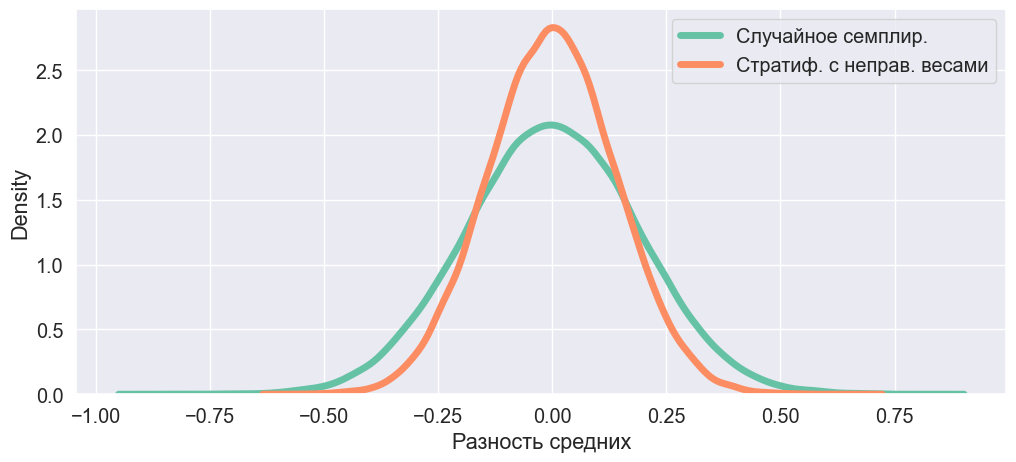

In [ ]:
labels = [
    'Случайное семплир.',
    'Стратиф. с неправ. весами',
]

plt.figure(figsize=(12, 5))
sns.kdeplot(means_random, lw=lw, label=labels[0])
sns.kdeplot(means_st_weighted, lw=lw, label=labels[1])
plt.xlabel('Разность средних')
plt.legend();

**Вывод:** разность средних при случайном семплировании все еще имеет большую дисперсию, чем при стратификации с неправильными весами, таким образом, увеличение ошибки первого рода связано не с увеличением дисперсии.

В чем же тогда проблема того, что стратифицированный t-test увеличивает вероятность ошибки 1 рода?

> Величина $\mathsf{D}_{st}$ была выведена в предположении правильной стратификации, то есть при $w_k = \frac{n_k}{\sum\limits_{i=1}^K n_i}$

Можно ли как-то исправить его с помощью некоторой универсальной статистической процедуры?

> Можно исправить, используя  бутстреп

Реализуем эту процедруру.

In [ ]:
def boots_weighted_means(data, B, n, strata_weights):
    '''
    Подсчет взвешенного среднего для бутстрепных выборок

    Аргументы:
    data -- датафрейм с полями 'strata' и 'sample'
    B -- количество бутстрепных выборок
    n -- размер бутстрепных выборок
    strata_weights -- веса среднего
    '''
    # генерируем бутстрепные выборки
    data_boot = data.sample(B * n, replace=True)

    # запоминаем номер выборки для каждого объекта
    data_boot['boot_num'] = np.arange(B).repeat(n)

    # считаем среднее в каждой страте по каждой бутстрепной выборке
    data_boot = pd.DataFrame(data_boot.groupby(by=['strata', 'boot_num'])['sample'].mean()).reset_index()

    # умножаем среднее страты на соответствующий вес
    data_boot = data_boot.join(strata_weights, on='strata', rsuffix='_r').drop(columns=['strata_r'])
    data_boot['sample'] = data_boot['sample'] * data_boot['weights']

    # суммируем взвешанные средние
    return data_boot.groupby(by='boot_num')['sample'].sum().values


def ttest_bootstrap(
    x, y, strata_weights, B=10000, alpha=0.05, return_bootstrap_stats=False
):
    '''
    Абсолютный t-test.

    Аргументы:
    x, y -- выборки одинакового размера
    B -- количество бутстрепных выборок
    alpha -- уровень значимости
    return_bootstrap_stats -- возвращать ли бутстрепную выборку статистик

    Возвращает:
    stat -- статистика критерия
    left_bound, right_bound -- границы дов. интервала
    pvalue
    bootstrap_stats -- если return_bootstrap_stats = True
    '''
    n = len(x)

    # таблица соответствия веса страты и ее номера
    strats2weights = pd.DataFrame()
    strats2weights['weights'] = strata_weights
    strats2weights['strata'] = np.arange(len(strata_weights))

    bootstrap_stats = \
        boots_weighted_means(x, B, n, strats2weights) - boots_weighted_means(y, B, n, strats2weights)

    stat = weighted_mean(x, strata_weights) - weighted_mean(y, strata_weights)

    # индексы для интервала
    left_index = max(0, int(np.floor(B*alpha/2)) - 1)
    right_index = min(B-1, int(np.ceil(B*(1-alpha/2))) - 1)

    # Границы интервала
    left_bound = bootstrap_stats[left_index]
    right_bound = bootstrap_stats[right_index]

    pvalue = 2 * min((bootstrap_stats > 0).mean(), (bootstrap_stats < 0).mean())

    if return_bootstrap_stats:
        return stat,  pvalue, left_bound, right_bound, bootstrap_stats
    else:
        return stat,pvalue,left_bound, right_bound


Функции для оценки мощности, оценки ошибки первого рода и сравнения с стратифицированным т-тестом:

In [ ]:
def estimate_reject_prob(n_rejects, n_iter):
    '''
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    '''

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(n_rejects, n_iter, method='wilson')

    return prob_reject, left_bound, right_bound

def visualization(prob_reject, left_bound, right_bound,
                  show_pvals=False, pvals=None, alpha=0.05, figsize=(7, 2), title=None):
    '''
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теор вероятность ошибки первого рода
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    '''

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(pvals, bins=np.linspace(0, 1, 21), alpha=0.7,
                    weights=np.ones(len(pvals)) / len(pvals))
            plt.title('Распределение p-value')

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound], [0.15]*2, [-0.15]*2,
            color='green', alpha=0.6
        )
        plt.scatter(prob_reject, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_bound)-1e-3, max(alpha, right_bound)+1e-3))
        plt.title(
            f'Доля отвержений = {100*prob_reject:.2f}%, '
            f'интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)'
        )
        plt.suptitle(title)
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()

def draw_power(powers, left_powers, right_powers, effects_list=np.linspace(0, 0.1, 11), label=None,
               title='Графики мощности', new_figure=False):
    '''
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    '''

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(0.8, effects_list[0], effects_list[-1], color='black', alpha=0.5,
                   label='Мощность 0.8 (пересечение — MDE)')
    plt.legend()
    plt.xlabel('Размер относительного эффекта')
    plt.ylabel('Мощность')
    plt.title(title)


In [ ]:
def add_effect(x, effect, target_name='sample', relative_effect=True):
    '''
    Функция искусственного добавления эффекта в тестовую выборку

    Аргументы:
    x -- выборка
    effect -- добавляемый эффект

    Возвращает:
    x -- выборка с добавленным эффектом
    '''

    x_copy = x.copy()
    if relative_effect:
        x_copy[target_name] *= (1 + effect)
    else:
        x_copy[target_name] += effect

    return x_copy


def run_experiments(
    test, generate_samples,
    n_iter=10000, sample_size=1000, effect=0, relative_effect=True,
    alpha=0.05, target_name='sample', draw=False, title=None, show_pvals=True,
):
    '''
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    '''

    n_rejects = 0  # количество отвержений H_0
    pvals = []  # значения p-value

    # Проведение экспериментов
    for _ in tqdm(range(n_iter), leave=False):
        # Генерируем выборки
        x_data, y_data = generate_samples(size=sample_size)

        # Добавляем эффект, если хотим оценить мощность
        x_data = add_effect(x_data, effect, target_name=target_name, relative_effect=relative_effect)

        # Применяем критерий
        pvals.append(test(x_data, y_data)[1])
        n_rejects += (pvals[-1] < alpha)

    # Оценка вероятности отвержения
    prob_reject, left_bound, right_bound = estimate_reject_prob(n_rejects, n_iter)

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            prob_reject, left_bound, right_bound, show_pvals,
            pvals, alpha, figsize, title
        )

    return prob_reject, (left_bound, right_bound)


def estimate_power(test, generate_samples,
    n_iter=10000, sample_size=1000, effects_list=np.linspace(0, 0.1, 11), relative_effect=True,
    alpha=0.05, target_name='sample'):

    powers = np.zeros(len(effects_list))
    left_bounds = np.zeros(len(effects_list))
    right_bounds = np.zeros(len(effects_list))

    for i, effect in tqdm(enumerate(effects_list), leave=False):
        powers[i], (left_bounds[i], right_bounds[i]) = run_experiments(
            test, generate_samples,
            n_iter=n_iter, sample_size=sample_size, effect=effect, relative_effect=relative_effect,
            alpha=alpha, target_name=target_name, draw=False,
        )

    return powers, left_bounds, right_bounds

Сам стратифицированный т-тест:

In [ ]:
def stratified_ttest(x_data, y_data, strata_weights=np.asarray([0.4, 0.6]), method='post_stratified', alpha=0.05):
    '''
    Стратифицированный абсолютный t-test.

    :param x_data: выборка вместе с информацией о стратах
    :param y_data: выборка вместе с информацией о стратах
    :param strata_weights: веса страт
    :param method: метод 'random', 'stratified', 'post_stratified'
    :param alpha: уровень значимости
    :return: статистика критерия, границы доверительного интервала, p-value
    '''

    if method == 'random':
        mean_function = simple_mean
        var_function = simple_var
    elif method == 'stratified':
        mean_function = weighted_mean
        var_function = weighted_var
    elif method == 'post_stratified':
        mean_function = weighted_mean
        var_function = weighted_post_var

    x_mean = mean_function(x_data, strata_weights)
    y_mean = mean_function(y_data, strata_weights)
    x_var  =  var_function(x_data, strata_weights)
    y_var  =  var_function(y_data, strata_weights)

    stat = x_mean - y_mean
    std = np.sqrt(x_var + y_var)

    t_stat = stat / std
    pvalue = 2*sps.norm.sf(np.abs(t_stat))

    q = sps.norm.ppf(1 - alpha/2)
    left_bound = stat - q*std
    right_bound = stat + q*std

    return stat, pvalue, left_bound, right_bound

Провалидируем полученный тест, а также сравним его по мощности со стандартным t-test.

Валидация:

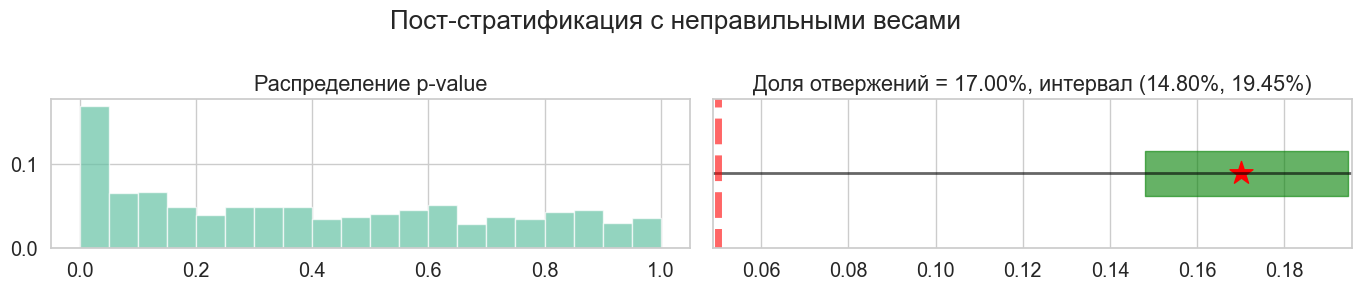

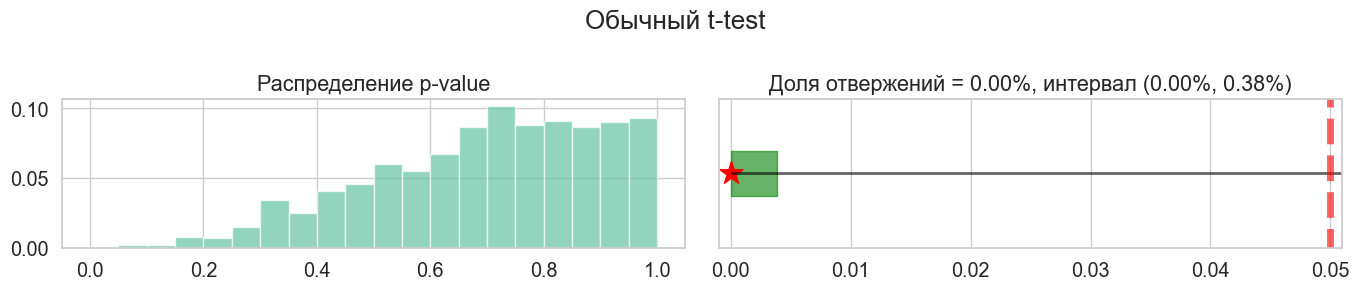

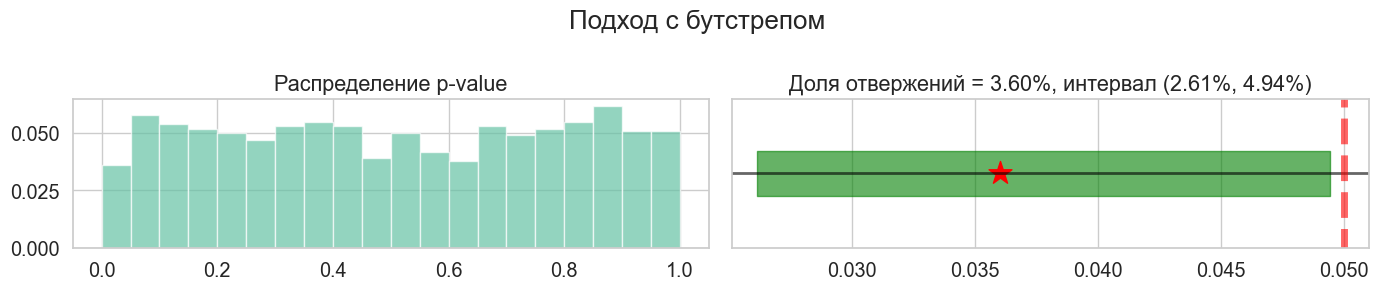

In [ ]:
n_iter_checking = 1000

test_list = [
    stratified_ttest,
    partial(stratified_ttest, method='random'),
    partial(ttest_bootstrap, strata_weights=np.asarray([0.4, 0.6]))
]

title_list = [
    'Пост-стратификация с неправильными весами',
    'Обычный t-test',
    'Подход с бутстрепом'
]

for test, title in zip(test_list, title_list):
    run_experiments(
        test=test,
        generate_samples = lambda size: weighted_sampler(data=data, sample_size=size, strata_weights=np.asarray([0.7, 0.3])),
        sample_size=sample_size,
        n_iter=n_iter_checking,
        draw=True,
        title=title,
    )

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

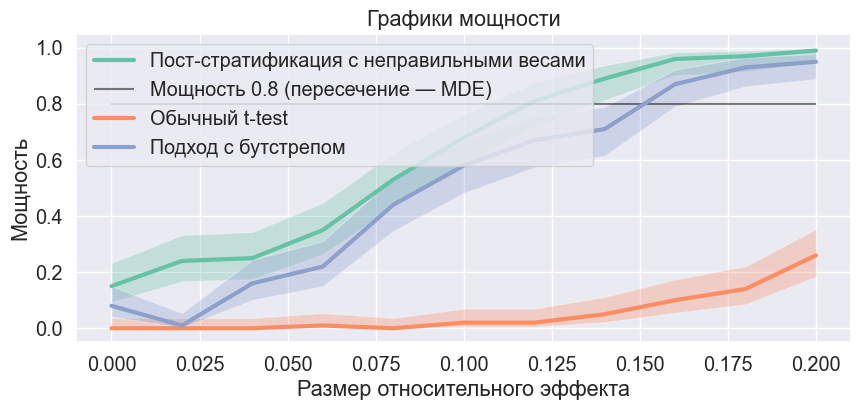

In [ ]:
for i, (test, title) in enumerate(zip(test_list, title_list)):
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples = lambda size: weighted_sampler(data=data, sample_size=size, strata_weights=np.asarray([0.7, 0.3])),
        sample_size=sample_size,
        effects_list=np.linspace(0, 0.2, 11),
        n_iter=n_iter_checking // 10,
    )

    draw_power(powers, left_bounds, right_bounds, label=title, new_figure=(i==0), effects_list=np.linspace(0, 0.2, 11))

**Выводы:**
1. Ошибки первого рода у стратифицированного т-теста повышается при изменении баланса страт. Поэтому сравнивать бутстрепный т-тест со стратифицированным некорректно, так как последний не является критерием заданного уровня значимости.
2. Также проведено сравнение с обычным т-тестом, видно, что он совсем не справляется, мощность у метода с бутстрепом гораздо выше (при эффекте 5%).
3. Видно, что бутстрепный критерий имеет хорошую мощность.